# Práctica Simpy Interrupciones

En base a la práctica del COVID vacunación, realizar el proceso de interrupción en base a que el 5% de los pacientes que estan en la sala de espera presentan complicaciones de salud y deben ser trasladados inmediatamente al centro de salud más cercano y ser atendidos. Realizar este proceso y generar una segunda linea de simulación para el traslado, atención y alta del paciente que presenta complicaciones en base a los siguientes datos:
    
- Traslado de la ambulancia 5 - 15 minutos.
- Atención en el centro de salud 5 - 24 horas.
- Alta 1 - 2 horas.
- El 10% de las personas presentan que presentaron complicaciones fallecen.

Generar gráficas que indiquen las personas que presentaron complicaciones en base a los tiempos, estado de las personas y respuesta.

## Desarrollo

Se declaran las variables necesarias y el tiempo de simulación, en este caso se simularán 6 días de vacunación trabajando 8 horas diarias.

In [36]:
TIEMPO_CONTROL = 20 # Tiempo que toma el control después de la vacuna
N_MESAS = 20 # Número de mesas de vacunación
TP_FALLA = 200

SEMANAS = 1 # Número de semanas que dura la simulación
TIEMPO_SIMULACIÓN = SEMANAS * 6 * 8 * 60 # Tiempo de simulación del centro de vacunación 6 días 8 horas

Se define la clase RegistrarPersona con las funciones para registrar el tiempo de vacunación por cada persona, registrar el número de complicaciones muertes y altas que existen en el proceso de vacunació. Además de llevar un conteo del total de personas que ingresan al centro de vacunación.

In [37]:
import simpy
import random

class RegistrarPersona(object):

    person_count = 0
    listaTiempoVacunacion = {}
    listaNoVacunados = []
    listaComplicaciones = []
    listaMuertes = []
    listaAltas = []

    def __init__(self):
        RegistrarPersona.person_count += 1
    
    def tiempoVacunacion(self, persona, tiempoVacunacion):
        RegistrarPersona.listaTiempoVacunacion[persona] = tiempoVacunacion
        
    def registroNoVacunados(self, persona):
        RegistrarPersona.listaNoVacunados.append(persona)
    
    def registroComplicaciones(self, persona):
        RegistrarPersona.listaComplicaciones.append(persona)
        
    def registroMuertes(self, persona):
        RegistrarPersona.listaMuertes.append(persona)
    
    def registroAltas(self, persona):
        RegistrarPersona.listaAltas.append(persona)

La clase Vacunación contiene la función procesoVacunacion en la que se realiza el proceso desde la llegada de la persona hasta que pasa o no el control y es derivada a un centro de salud.

- Dentro de la función procesoVacunacion se realiza el registro de la llegada de una nueva persona al centro de vacunación formando parte del registro total de asistentes.

- La persona tarda 1 minuto en pasar de la entrada a la sala donde se verifican sus datos.

- Se cumple con que solamente entre el 5-10% de las personas no pueden realizar el proceso de vacunación.

- Se aplica la vacuna (5-10 mins) y la persona pasa a la sala de control donde deberá esperar 20 minutos.

La función problemaPersona es la encargada de generar una interrupción solamente cuando una persona se encuentra en la sala de control, si se cumple con la condición que el 5% de las personas presentan una complicación y si la persona no presentó ya una complicación.

- Paso siguiente la persona es derivada a un centro de salud.

In [38]:
class Vacunacion():
    
    def __init__(self, env, nombre, centro):
        self.env = env
        self.nombre = nombre
        self.numeroPersonas = 0
        self.falla = False
        self.control = False
        self.proceso = env.process(self.procesoVacunacion())
        env.process(self.problemaPersona())
        
    def procesoVacunacion(self):
        while True:
            #print(Person.person_count)
            nuevaPersona = RegistrarPersona()
            
            # id Persona 
            idPersona = nuevaPersona.person_count
            
            # La persona llega al centro de vacunación
            print('→ La persona %d llega al recinto a la hora %.2f.' % (idPersona, env.now))       
            
            # La persona pasa a la sala de control y verifica sus datos
            yield self.env.timeout(1)
            
            # Entre el 5% y 10% de las personas no cumplen con las condiciones para ser vacunadas.
            rand = random.randint(1,100)
            if rand <= 10:
                print('La persona %d no puede ser vacunada' % idPersona)
                nuevaPersona.registroNoVacunados(idPersona)
            else:
                # Indicamos que la persona entra en el proceso de vacunación
                print('La persona %d pasa a la silla de vacunación a la hora %.2f.' % (idPersona, env.now))
                
                # Inicia el tiempo de la vacunación
                inicio = env.now
    
                # Se realiza la aplicación de la vacuna
                yield self.env.timeout(random.randint(5,10))
            
                # Se indica que se ha vacunado la persona
                print('La persona %d fue vacunada a las %.2f.' % (idPersona, env.now)) 
                nuevaPersona.tiempoVacunacion(idPersona, env.now-inicio)
                
                # Despues de la vacunación la persona pasa a un control donde debe esperar 20 minutos 
                # mientras se verifica que no tenga problemas de salud.
                print('La persona %d pasa al control post-vacuna a las %.2f.' % (idPersona, env.now))
            
            # Mientras se espera que la persona pase el control después de la vacunación.
            tiempoControl = TIEMPO_CONTROL
            try:
                inicio = self.env.now
                self.control = True
                yield self.env.timeout(tiempoControl)
                tiempoControl = 0
                self.control = False
                print('✅ La persona %d supera el control a las %.2f ✅' % (idPersona, env.now))
                yield self.env.timeout(1)
                print('La persona %d recibe su certificado y se retira del centro de salud a las %.2f' % (idPersona, env.now))
                
            except simpy.Interrupt:
                self.falla = True
                print('\033[91m ❌ La persona %d presenta complicaciones de salud ❌ \033[0m' % idPersona)
                nuevaPersona.registroComplicaciones(idPersona)
                tiempoControl -= self.env.now - inicio
                with centro.request() as requerimiento:
                    yield requerimiento
                    env.process(procedimientoEmergencia(self.env, idPersona, nuevaPersona))
                self.falla = False
            self.numeroPersonas += 1
        
        # Wait cada 20 mins y preguntar si esta vacunandose
    def problemaPersona(self):
        while True:
            yield self.env.timeout(26)
            if self.control and random.randint(1,100) <= 5:
                if not self.falla:
                    self.proceso.interrupt()     

- El proceso cuando una persona presenta una complicación parte desde el traslado en ambulancia, un proceso que tarda entre 5 y 10 minutos.

- Después la persona es atendida entre 5-24 horas.

- Dentro del centro de salud existe el caso en el que el 10% de las personas fallecen.

- Si la persona no se encuentra dentro de ese 5% el proceso de recibir el alta médica tarda entre 1-2 horas.

In [39]:
def procedimientoEmergencia(env, persona, personaClass):
    # La persona se traslada en ambulancia
    print('La persona %d es trasladada en ambulancia a un centro de salud a la hora %.2f' % (persona, env.now))
    yield env.timeout(random.randint(5,15)) 
    
    # Se atiende a la persona en el centro de salud
    print('La persona %d comienza a ser atendida a la hora %.2f' % (persona, env.now))
    yield env.timeout(random.randint(300, 1440))
    
    # El 10% de las personas presentan que presentaron complicaciones fallecen.
    randDeath = random.randint(1, 100)
    if(randDeath <= 10):
        print('☠️ Ha fallecido la persona %d a la hora %.2f RIP ☠️' % (persona, env.now))
        personaClass.registroMuertes(persona)
    else:
        # La persona recibe el alta
        yield env.timeout(random.randint(60, 120))
        print('La persona %d recibe el alta a la hora %.2f' % (persona, env.now))
        personaClass.registroAltas(persona)

## Resultados
Para la simulación existen 2 centros de salud, 20 mesas de vacunación y el tiempo asignado anteriormente.

- La simulación muestra la llegada de una persona.
- Si la persona no puede ser vacunada o el caso contrario en el que pasa a la silla de vacunación.
- La aplicación de la dosis y el proceso de espera en la sala de control post vacuna.
- Si se presenta una complicación la persona comienza su traslado a un centro de salud y comienza la atención médica.
- Si no presenta complicaciones la persona sale del centro de vacunación después de recibir su certificado.

In [40]:
import simpy
import random

print('Vacunación COVID UPS')

env = simpy.Environment()
centro = simpy.Resource(env, capacity=2)
vacunacion = [Vacunacion(env, 'Mesa %d' % i, centro) for i in range(N_MESAS)]
env.run(until = TIEMPO_SIMULACIÓN)
print('Simulación realizada después de %d semanas' % SEMANAS)
for vac in vacunacion:
    print('Nombre: %s ha vacunado a %d personas'%(vac.nombre, vac.numeroPersonas))

Vacunación COVID UPS
→ La persona 1 llega al recinto a la hora 0.00.
→ La persona 2 llega al recinto a la hora 0.00.
→ La persona 3 llega al recinto a la hora 0.00.
→ La persona 4 llega al recinto a la hora 0.00.
→ La persona 5 llega al recinto a la hora 0.00.
→ La persona 6 llega al recinto a la hora 0.00.
→ La persona 7 llega al recinto a la hora 0.00.
→ La persona 8 llega al recinto a la hora 0.00.
→ La persona 9 llega al recinto a la hora 0.00.
→ La persona 10 llega al recinto a la hora 0.00.
→ La persona 11 llega al recinto a la hora 0.00.
→ La persona 12 llega al recinto a la hora 0.00.
→ La persona 13 llega al recinto a la hora 0.00.
→ La persona 14 llega al recinto a la hora 0.00.
→ La persona 15 llega al recinto a la hora 0.00.
→ La persona 16 llega al recinto a la hora 0.00.
→ La persona 17 llega al recinto a la hora 0.00.
→ La persona 18 llega al recinto a la hora 0.00.
→ La persona 19 llega al recinto a la hora 0.00.
→ La persona 20 llega al recinto a la hora 0.00.
La perso

La persona 320 pasa al control post-vacuna a las 450.00.
La persona 321 fue vacunada a las 450.00.
La persona 321 pasa al control post-vacuna a las 450.00.
La persona 322 fue vacunada a las 450.00.
La persona 322 pasa al control post-vacuna a las 450.00.
La persona 324 pasa a la silla de vacunación a la hora 450.00.
La persona 325 pasa a la silla de vacunación a la hora 450.00.
✅ La persona 308 supera el control a las 451.00 ✅
La persona 305 recibe su certificado y se retira del centro de salud a las 451.00
→ La persona 326 llega al recinto a la hora 451.00.
La persona 308 recibe su certificado y se retira del centro de salud a las 452.00
→ La persona 327 llega al recinto a la hora 452.00.
La persona 326 pasa a la silla de vacunación a la hora 452.00.
La persona 327 pasa a la silla de vacunación a la hora 453.00.
✅ La persona 307 supera el control a las 454.00 ✅
✅ La persona 309 supera el control a las 455.00 ✅
✅ La persona 310 supera el control a las 455.00 ✅
✅ La persona 311 supera e

→ La persona 744 llega al recinto a la hora 1044.00.
La persona 742 no puede ser vacunada
✅ La persona 726 supera el control a las 1045.00 ✅
La persona 724 comienza a ser atendida a la hora 1045.00
La persona 743 pasa a la silla de vacunación a la hora 1045.00.
La persona 744 pasa a la silla de vacunación a la hora 1045.00.
✅ La persona 725 supera el control a las 1046.00 ✅
✅ La persona 728 supera el control a las 1046.00 ✅
La persona 739 fue vacunada a las 1046.00.
La persona 739 pasa al control post-vacuna a las 1046.00.
La persona 740 fue vacunada a las 1046.00.
La persona 740 pasa al control post-vacuna a las 1046.00.
La persona 726 recibe su certificado y se retira del centro de salud a las 1046.00
→ La persona 745 llega al recinto a la hora 1046.00.
✅ La persona 727 supera el control a las 1047.00 ✅
La persona 738 fue vacunada a las 1047.00.
La persona 738 pasa al control post-vacuna a las 1047.00.
La persona 725 recibe su certificado y se retira del centro de salud a las 1047.00

La persona 1039 pasa a la silla de vacunación a la hora 1457.00.
La persona 1035 fue vacunada a las 1458.00.
La persona 1035 pasa al control post-vacuna a las 1458.00.
✅ La persona 1019 supera el control a las 1460.00 ✅
✅ La persona 1021 supera el control a las 1461.00 ✅
La persona 1031 comienza a ser atendida a la hora 1461.00
La persona 1019 recibe su certificado y se retira del centro de salud a las 1461.00
→ La persona 1040 llega al recinto a la hora 1461.00.
✅ La persona 1020 supera el control a las 1462.00 ✅
La persona 1036 fue vacunada a las 1462.00.
La persona 1036 pasa al control post-vacuna a las 1462.00.
La persona 1037 fue vacunada a las 1462.00.
La persona 1037 pasa al control post-vacuna a las 1462.00.
La persona 1039 fue vacunada a las 1462.00.
La persona 1039 pasa al control post-vacuna a las 1462.00.
La persona 1021 recibe su certificado y se retira del centro de salud a las 1462.00
→ La persona 1041 llega al recinto a la hora 1462.00.
La persona 1040 pasa a la silla d

La persona 1281 fue vacunada a las 1809.00.
La persona 1281 pasa al control post-vacuna a las 1809.00.
La persona 1282 fue vacunada a las 1809.00.
La persona 1282 pasa al control post-vacuna a las 1809.00.
La persona 1284 fue vacunada a las 1809.00.
La persona 1284 pasa al control post-vacuna a las 1809.00.
✅ La persona 1269 supera el control a las 1810.00 ✅
La persona 1279 fue vacunada a las 1810.00.
La persona 1279 pasa al control post-vacuna a las 1810.00.
La persona 1269 recibe su certificado y se retira del centro de salud a las 1811.00
→ La persona 1289 llega al recinto a la hora 1811.00.
La persona 1289 pasa a la silla de vacunación a la hora 1812.00.
✅ La persona 1270 supera el control a las 1814.00 ✅
✅ La persona 1277 supera el control a las 1814.00 ✅
La persona 1288 fue vacunada a las 1814.00.
La persona 1288 pasa al control post-vacuna a las 1814.00.
La persona 1270 recibe su certificado y se retira del centro de salud a las 1815.00
→ La persona 1290 llega al recinto a la ho

La persona 1551 recibe su certificado y se retira del centro de salud a las 2217.00
→ La persona 1574 llega al recinto a la hora 2217.00.
La persona 1557 recibe su certificado y se retira del centro de salud a las 2217.00
→ La persona 1575 llega al recinto a la hora 2217.00.
✅ La persona 1554 supera el control a las 2218.00 ✅
La persona 1574 pasa a la silla de vacunación a la hora 2218.00.
La persona 1575 pasa a la silla de vacunación a la hora 2218.00.
La persona 1568 fue vacunada a las 2219.00.
La persona 1568 pasa al control post-vacuna a las 2219.00.
La persona 1554 recibe su certificado y se retira del centro de salud a las 2219.00
→ La persona 1576 llega al recinto a la hora 2219.00.
La persona 1567 fue vacunada a las 2220.00.
La persona 1567 pasa al control post-vacuna a las 2220.00.
La persona 1576 pasa a la silla de vacunación a la hora 2220.00.
La persona 1569 fue vacunada a las 2222.00.
La persona 1569 pasa al control post-vacuna a las 2222.00.
✅ La persona 1555 supera el co

La persona 1836 pasa a la silla de vacunación a la hora 2593.00.
✅ La persona 1818 supera el control a las 2594.00 ✅
✅ La persona 1821 supera el control a las 2594.00 ✅
✅ La persona 1822 supera el control a las 2594.00 ✅
La persona 1833 fue vacunada a las 2594.00.
La persona 1833 pasa al control post-vacuna a las 2594.00.
La persona 1837 pasa a la silla de vacunación a la hora 2594.00.
La persona 1838 pasa a la silla de vacunación a la hora 2594.00.
La persona 1839 no puede ser vacunada
La persona 1835 fue vacunada a las 2595.00.
La persona 1835 pasa al control post-vacuna a las 2595.00.
La persona 1818 recibe su certificado y se retira del centro de salud a las 2595.00
→ La persona 1840 llega al recinto a la hora 2595.00.
La persona 1821 recibe su certificado y se retira del centro de salud a las 2595.00
→ La persona 1841 llega al recinto a la hora 2595.00.
La persona 1822 recibe su certificado y se retira del centro de salud a las 2595.00
→ La persona 1842 llega al recinto a la hora 

#### Gráficas del porcentaje de las personas que, fueron vacunadas, no vacunadas o presentaron complicaciones.

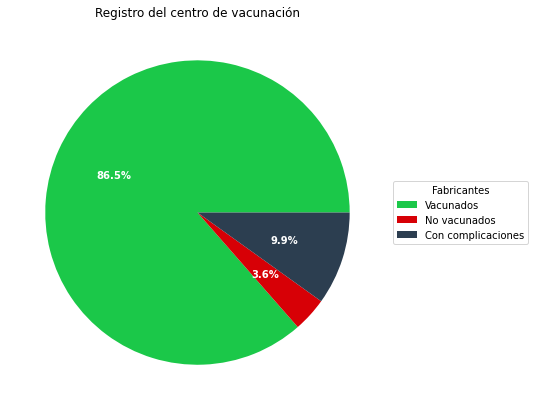

In [52]:
# Gráficas
import matplotlib.pyplot as plt 
x = len(RegistrarPersona.listaTiempoVacunacion)
y = len(RegistrarPersona.listaComplicaciones)
z = len(RegistrarPersona.listaNoVacunados)

plt.figure(figsize=(12,7))
etiquetas = ['Vacunados', 'No vacunados', 'Con complicaciones']
colors = ['#1BC849','#D70006','#2C3E50']
plt.pie([x,y,z], autopct='%1.1f%%', startangle=0,colors=colors,textprops={'color':"w",'weight':'bold'})
plt.title('Registro del centro de vacunación')
plt.legend(etiquetas, title="Fabricantes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

#### Gráficas del porcentaje de las personas que recibieron el alta o fallecieron luego de presentar complicaciones.

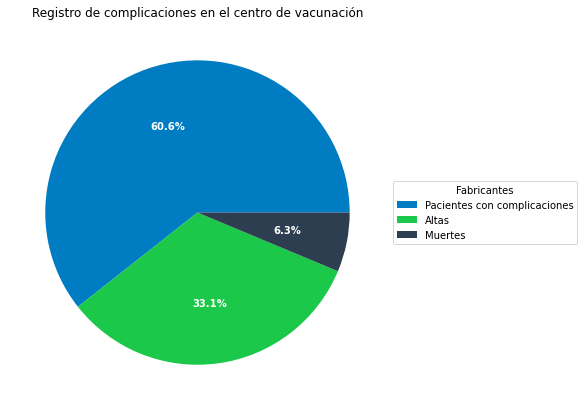

In [53]:
# Gráficas
import matplotlib.pyplot as plt 
x = len(RegistrarPersona.listaComplicaciones)
y = len(RegistrarPersona.listaAltas)
z = len(RegistrarPersona.listaMuertes)

plt.figure(figsize=(12,7))
etiquetas = ['Pacientes con complicaciones','Altas','Muertes']
colors = ['#007CC2','#1BC849','#2C3E50']
plt.pie([x,y,z], autopct='%1.1f%%', startangle=0,colors=colors,textprops={'color':"w",'weight':'bold'})
plt.title('Registro de complicaciones en el centro de vacunación')
plt.legend(etiquetas, title="Fabricantes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [54]:
count = 0
_sum = 0
for key in RegistrarPersona.listaTiempoVacunacion:
    count += 1
    _sum += RegistrarPersona.listaTiempoVacunacion[key]

print('Promedio del tiempo de vacunación: ', _sum/count)

Promedio del tiempo de vacunación:  7.476712328767123


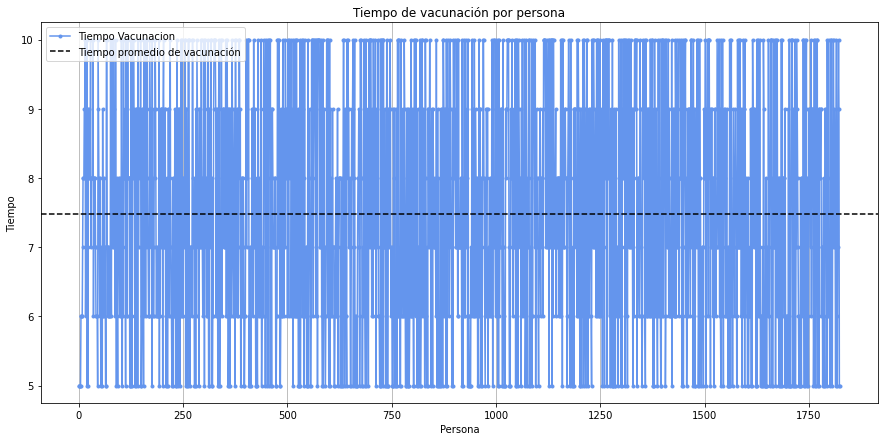

In [55]:
plt.figure(figsize = (15,7))

plt.title("Tiempo de vacunación por persona")
plt.xlabel("Persona")
plt.ylabel("Tiempo")

#list(TIEMPOVACUNACIONDICT.keys())
plt.plot(range(len(RegistrarPersona.listaTiempoVacunacion)), RegistrarPersona.listaTiempoVacunacion.values(), '.-', label='Tiempo Vacunacion', color='cornflowerblue')

plt.axhline(y=_sum/count, color='black', label='Tiempo promedio de vacunación', linestyle='--')



plt.grid(axis='x')

plt.legend(loc="upper left")

plt.show()

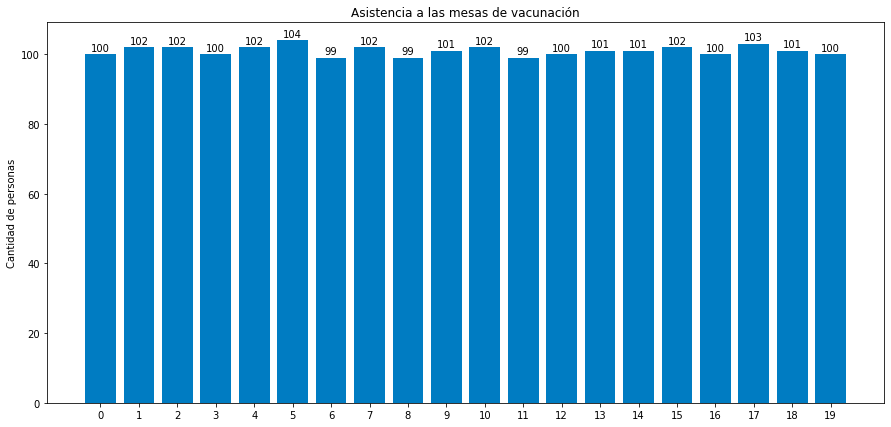

In [56]:
# Carga de las N mesas de vacunación
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(N_MESAS)

tags = ['Asistentes','Vacunados', 'No Vacunados']

fig, ax = plt.subplots(figsize=(15,7))

i=0
labels = []
for vac in vacunacion:
    rects1 = ax.bar(x[i], vac.numeroPersonas, label='Asistentes', color="#007CC2")
    labels.append(vac.numeroPersonas)
    i +=1

ax.set_ylabel('Cantidad de personas')
ax.set_title('Asistencia a las mesas de vacunación')
ax.set_xticks(x)

rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.5, label,
            ha='center', va='bottom')

plt.show()